# `StudentTReparam` posteriors

This notebook examines the posteriors over the four latent variables introduced by `StudentTReparam`, conditioned on a single datum and the `StudentT` parameters. Our goal is to assess the accuracy of an `AutoNormal` approximation to this posterior, addressing [Pyro issue #3280](https://github.com/pyro-ppl/pyro/issues/3280).

In [9]:
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.reparam import StudentTReparam
from pyro.nn.module import PyroModule, PyroParam
from pyro.optim import ClippedAdam
import matplotlib as mpl
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(20231006)
mpl.rcParams['figure.facecolor'] = 'white'

In [10]:
loc = 0.0
scale = 1.0
df = 1.0
student_t = dist.StudentT(df, loc, scale)

In [11]:
@poutine.reparam(config={"x": StudentTReparam()})
def model(data: torch.Tensor):
    with pyro.plate("data", len(data)):
        pyro.sample("x", student_t, obs=data)

Let's sample some representative points.

In [12]:
data = student_t.sample([10001])
data, _ = data.sort()
data.shape

torch.Size([10001])

Text(0.5, 1.0, 'Approximate CDF')

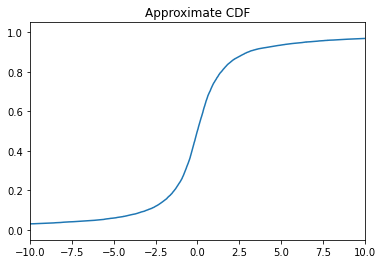

In [13]:
plt.plot(data, torch.linspace(0, 1, len(data)))
plt.xlim(-10, 10)
plt.title("Approximate CDF")

In [14]:
quantiles = torch.tensor([-5.0, -2.5, 0.0, 2.5, 5.0])

In [66]:
# draw samples using Pyro's NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=4000, warmup_steps=400)
mcmc.run(quantiles)
samples = mcmc.get_samples()

Sample: 100%|███████████████████████████████████████| 4400/4400 [00:12, 364.21it/s, step size=4.23e-01, acc. prob=0.933]                


In [67]:
{k: v.shape for k, v in sorted(samples.items())}

{'x_gamma': torch.Size([4000, 5])}

In [68]:
z = samples["x_gamma"]
z.shape

torch.Size([4000, 5])

In [69]:
mcmc.transforms

{'x_gamma': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 )}

In [70]:
z_unconstrained = mcmc.transforms["x_gamma"](z)

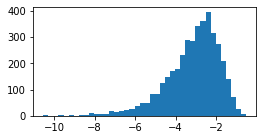

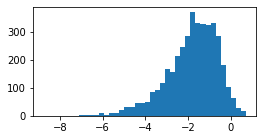

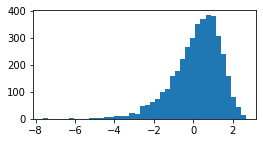

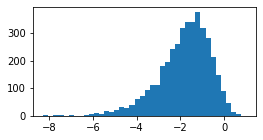

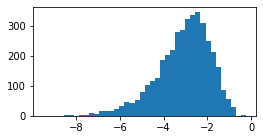

In [71]:
for i in range(5):
    plt.figure(figsize=(4, 2))
    plt.hist(z_unconstrained[:, i].numpy(), bins=40, lw=0);

## Fitting a conditional normalizing flow

Let's fit a conditional normalizing flow that depends only on the data point. In a real application we'd want to additionally depend on the local parameters of the stable distribution (stability, skew, scale, and loc).

In [74]:
pyro.set_rng_seed(20231007)
data = student_t.sample([10000])

In [82]:
class AmortizedNormalGuide(PyroModule):
    def __init__(self, data: torch.Tensor, hidden_dim=10):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, 2),
        )

        with torch.no_grad():
            mean = self.net(data[..., None]).mean(dim=0)
            # Initialize to zero mean, small variance.
            self.net[-1].bias.data -= mean
            self.net[-1].bias.data[1] -= 5
            print(self.net(data[..., None]).mean(dim=0))


    def forward(self, data: torch.Tensor):
        loc, scale = self.net(data[..., None]).unbind(-1)
        scale = torch.nn.functional.softplus(scale)
        with pyro.plate("data", len(data)):
            z = pyro.sample(
                "z",
                dist.TransformedDistribution(
                    dist.Normal(loc, scale),
                    dist.transforms.SoftplusTransform(),
                ),
                infer={"is_auxiliary": True},
            )
            pyro.sample("x_gamma", dist.Delta(z))
        return z
        

tensor([-1.5810e-17, -5.0000e+00])
step:    0 loss: 584.42
step:  500 loss: 227.57
step: 1000 loss: 2.6
step: 1500 loss: 2.5671
step: 2000 loss: 2.531
step: 2500 loss: 2.6598
step: 3000 loss: 2.5293
step: 3500 loss: 2.5423
step: 4000 loss: 2.5096
step: 4500 loss: 2.503
step: 5000 loss: 2.5788
step: 5500 loss: 2.489
step: 6000 loss: 2.513
step: 6500 loss: 2.541
step: 7000 loss: 2.5383
step: 7500 loss: 2.5904
step: 8000 loss: 2.4698
step: 8500 loss: 2.6248
step: 9000 loss: 2.5201
step: 9500 loss: 2.4618
step: 10000 loss: 2.6024


(2.319406986656819, 584.4193379703773)

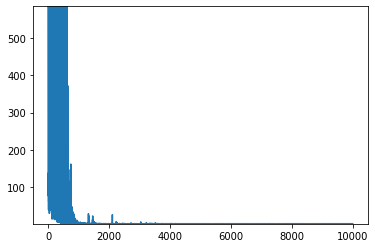

In [83]:
pyro.clear_param_store()
pyro.set_rng_seed(20231007)

num_steps = 10001
guide = AmortizedNormalGuide(data)
elbo = Trace_ELBO()
optim = ClippedAdam({"clip_norm": 100, "lr": 0.002, "lrd": 0.1**(1 / num_steps)})
svi = SVI(model, guide, optim, elbo)
losses = []
for step in range(num_steps):
    batch = data[torch.randint(len(data), (1000,))]
    loss = svi.step(batch) / len(batch)
    losses.append(loss)
    if step % 500 == 0:
        print(f"step: {step: >4d} loss: {loss:0.5g}")

plt.plot(losses)
plt.ylim(min(losses), losses[0])

In [86]:
with torch.no_grad(), pyro.plate("samples", 4000):
    svi_samples = dist.transforms.SoftplusTransform().inv(guide(quantiles[:, None]))
svi_samples.shape

torch.Size([5, 4000])

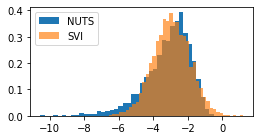

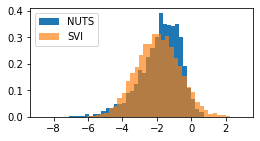

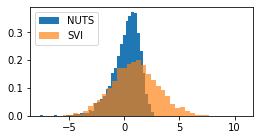

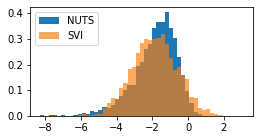

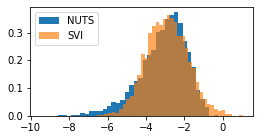

In [93]:

for i in range(len(quantiles)):
    plt.figure(figsize=(4, 2))
    plt.hist(z_unconstrained[:, i].numpy(), bins=40, lw=0, color="C0", alpha=1, label="NUTS", density=True)
    plt.hist(svi_samples[i].numpy(), bins=40, lw=0, color="C1", alpha=0.666, label="SVI", density=True)
    plt.legend(loc="upper left");